In [325]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator

In [326]:
import re

In [327]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [328]:
data_path = "/Users/jahrios/Documents/Stanford/PoldrackLab/Projects/SharedControl/Data/raw/"
exp_stage = "final"
task = "shared_control"

pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')

data_files = glob.glob(pattern)

In [329]:
def get_subject_label(file):
    
    match = re.search(r'/sub-(s\d{3})/', file)
    
    if match:
        subject_label = match.group(1)
        print("Subject label:", subject_label)
        return subject_label
    else:
        print("No subject label found.")
        return None

In [330]:
def string_to_numbers(string_data):
    if isinstance(string_data, float):  # Check if the input is already a float
        return [string_data]  # If it's a float, return it as a list
    string_data = string_data.strip("'")  # Remove leading and trailing single quotes
    numbers = [float(num) for num in string_data.split()]
    return numbers

In [331]:
def process_trial_data(data, block, min_delay=0.175, threshold_reduction=0.30):
    trial_results = {}
    ssrt_list = []

    for idx, row in data.iterrows():
        trial_number = idx
        stop_onset = row['SSD_mean']
        time_stamps = row['time_stamps_raw']
        pressures_raw = row['pressures_raw']
        condition = row['condition']

        # Calculate the minimum time to start checking for inhibition
        start_check_time = stop_onset + min_delay

        # Find the index where to start checking (first index after the start_check_time)
        index_of_start_check = next((i for i, t in enumerate(time_stamps) if t >= start_check_time), None)

        index_of_inhibition = None
        stop_moment = None
        moment_of_inhibition = None

        # Find the start of inhibition (first point where pressure reduces by at least 30% monotonically)
        if index_of_start_check is not None:
            for i in range(index_of_start_check, len(pressures_raw) - 1):
                current_pressure = pressures_raw[i]
                target_pressure = current_pressure * (1 - threshold_reduction)
                # Check if the pressure decreases to below the target and stays below it for a sequence
                if pressures_raw[i] > target_pressure:
                    if all(pressures_raw[j] <= pressures_raw[i] for j in range(i+1, min(i+5, len(pressures_raw)))):
                        if any(pressures_raw[j] <= target_pressure for j in range(i+1, min(i+5, len(pressures_raw)))):
                            moment_of_inhibition = time_stamps[i]
                            index_of_inhibition = i
                            break

        # Find the end of inhibition (first zero pressure after the start of inhibition)
        if index_of_inhibition is not None:
            stop_moment_indices = [i for i in range(index_of_inhibition, len(pressures_raw)) if pressures_raw[i] == 0]
            if stop_moment_indices:
                stop_moment = time_stamps[stop_moment_indices[0]]
                
        # Calculate SSRT if both inhibition start and stop moments are identified
        if stop_onset is not None and moment_of_inhibition is not None:
            ssrt = moment_of_inhibition - stop_onset
            ssrt_list.append(ssrt)
        else:
            print(f'Trial {idx} has no SSRT, condition = {condition} // block = {block}')
            ssrt = np.nan
            ssrt_list.append(ssrt)

        # Store the results in the dictionary
        trial_results[trial_number] = {
            'stop_onset': stop_onset,
            'stop_moment': stop_moment,
            'moment_of_inhibition': moment_of_inhibition,
            'index_of_inhibition': index_of_inhibition,
            'distances_raw': row['distances_raw'],
            'pressures_raw': pressures_raw,
            'time_stamps_raw': time_stamps,
            'condition': condition,
            'post_buffer_stamp': start_check_time,
            'ssrt': ssrt
        }

    return trial_results, ssrt_list


In [332]:
shared_control_metrics = {}

for file in data_files:
    subject_label = get_subject_label(file)
    
    df = pd.read_csv(file)
    
    # some post processing
    df['phase_raw'] = df['phase_raw'].str.strip("'")
    df['block_raw'] = df['block_raw'].str.strip("'")
    
    df_test = df.query("phase_raw == 'test'")
    block_1 = df_test.query("block_raw == 'block 1'")
    block_2 = df_test.query("block_raw == 'block 2'")
    block_1 = block_1.reset_index(drop=True)
    block_2 = block_2.reset_index(drop=True)

    task_dfs = [block_1, block_2]
    
    for df in task_dfs:
        if 'ai' in df['condition'].values:
            ai_data = df.copy()
            ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
            ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
            ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
        else:
            control_data = df.copy()
            control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
            control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
            control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)
    
    shared_control_metrics[subject_label] = {'ai': {'data': ai_data}, 'non_ai': {'data': control_data}}
    
    for block in shared_control_metrics[subject_label].keys():
        trial_results, ssrt_list = process_trial_data(shared_control_metrics[subject_label][block]['data'], block=block)
        shared_control_metrics[subject_label][block]['trial_results'] = trial_results
        shared_control_metrics[subject_label][block]['ssrt_list'] = ssrt_list 
    
    print(f"Done: {subject_label}")

Subject label: s016
Trial 73 has no SSRT, condition = ai // block = ai
Trial 93 has no SSRT, condition = ai // block = ai
Trial 35 has no SSRT, condition = stop // block = non_ai
Done: s016
Subject label: s011
Trial 14 has no SSRT, condition = stop // block = non_ai
Done: s011
Subject label: s018
Trial 34 has no SSRT, condition = stop // block = non_ai
Trial 35 has no SSRT, condition = stop // block = non_ai
Trial 58 has no SSRT, condition = stop // block = non_ai
Done: s018
Subject label: s019
Trial 18 has no SSRT, condition = stop // block = non_ai
Done: s019
Subject label: s010
Trial 41 has no SSRT, condition = stop // block = non_ai
Done: s010
Subject label: s017
Done: s017
Subject label: s004
Done: s004
Subject label: s005
Done: s005
Subject label: s012
Trial 80 has no SSRT, condition = stop // block = ai
Trial 2 has no SSRT, condition = stop // block = non_ai
Trial 15 has no SSRT, condition = stop // block = non_ai
Trial 32 has no SSRT, condition = stop // block = non_ai
Trial 34

In [333]:
condition_ssrt = {}

for subject in shared_control_metrics.keys():
    non_ai_condition_stop_trials = []
    ai_condition_stop_trials = []
    ai_condition_ai_trials = []
    
    for block in shared_control_metrics[subject].keys():
        
        for trial in shared_control_metrics[subject][block]['trial_results'].keys():
            
            if block == 'non_ai':
                non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial]['ssrt'])
                
            elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial]['ssrt'])
                
            elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                ai_condition_ai_trials.append(shared_control_metrics[subject][block]['trial_results'][trial]['ssrt'])
                
            else:
                print("Something fucked up boss...")
    
    avg_ai_ai_ssrt = np.nanmean(ai_condition_ai_trials)
    avg_ai_stop_ssrt = np.nanmean(ai_condition_stop_trials)
    avg_non_ai_stop_ssrt = np.nanmean(non_ai_condition_stop_trials)
    
    condition_ssrt[subject] = {'non_ai_stop_ssrt': avg_non_ai_stop_ssrt, 'ai_stop_ssrt': avg_ai_stop_ssrt, 'ai_ai_ssrt': avg_ai_ai_ssrt}
            

In [334]:
df_ssrt = pd.DataFrame(condition_ssrt).T
df_ssrt = df_ssrt.sort_index()

In [336]:
df_ssrt.to_csv('output/shared_control_metrics.csv')

In [335]:
df_ssrt

,non_ai_stop_ssrt,ai_stop_ssrt,ai_ai_ssrt
s004,0.222370,0.242520,0.254993
s005,0.219656,0.232827,0.259066
s006,0.252159,0.256714,0.293052
s007,0.258807,0.284119,0.338084
s008,0.240625,0.255048,0.296495
s009,0.222365,0.259465,0.255665
s010,0.245595,0.249927,0.257013
s011,0.213192,0.246637,0.250062
s012,0.219486,0.240208,0.233554
s013,0.266719,0.269863,0.341452


### Displaying Trials for QC

In [310]:
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator

In [311]:
def plot_trial_pressure_individual(trial_data, trial_number, ax, color):
    pressures_raw = trial_data['pressures_raw']
    time_stamps_raw = trial_data['time_stamps_raw']
    stop_onset_time = trial_data.get('stop_onset', None)
    moment_of_inhibition = trial_data.get('moment_of_inhibition', None)
    stop_moment = trial_data.get('stop_moment', None)
    post_buffer_stamp = trial_data.get('post_buffer_stamp', None)

    # Plotting all pressures
    ax.plot(time_stamps_raw, pressures_raw, label=f'Trial {trial_number}', color=color)

    # Adding vertical dotted lines at critical points if available
    if stop_onset_time is not None:
        ax.axvline(x=stop_onset_time, color='black', linestyle='dotted', linewidth=2, label='Stop Onset')
    if moment_of_inhibition is not None:
        ax.axvline(x=moment_of_inhibition, color='green', linestyle='dotted', linewidth=2, label='Moment of Inhibition')
    if stop_moment is not None:
        ax.axvline(x=stop_moment, color='red', linestyle='dotted', linewidth=2, label='Stop Moment')
    if post_buffer_stamp is not None:
        ax.axvline(x=post_buffer_stamp, color='purple', linestyle='dotted', linewidth=2, label='Post Buffer Stamp')

    # Setting axis labels, title, and grid
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Raw Pressure')
    ax.set_title(f'Trial {trial_number}')
    ax.legend()
    ax.grid(True)

    # Set fixed y-axis and x-axis limits
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlim(0, 6)  # Set x-axis limits from 0 to 6 seconds

    # Set x-axis major and minor ticks
    ax.xaxis.set_major_locator(MultipleLocator(1))  # Major ticks at every second
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))  # Minor ticks at every 100 ms

In [312]:
def diaplay_subject_trials(subject, block, data = shared_control_metrics):
    
    # plotting individual AI block trials
    num_trials_ai = len(data[subject][block]['trial_results'])
    num_cols = 2
    num_rows = (num_trials_ai + 1) // 2  # Add 1 to round up

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), squeeze=False)  # Ensure axs is always a 2D array
    
    # notes. if its an AI trial the trial will be blue, if its a stop then red
    ai_color = 'blue'
    stop_color = 'red'

    for i, (trial_number, trial_data) in enumerate(data[subject][block]['trial_results'].items()):
        row = i // num_cols
        col = i % num_cols
        condition = trial_data['condition']
        color = ai_color if condition == 'ai' else stop_color
        plot_trial_pressure_individual(trial_data, trial_number, axs[row, col], color=color)

    plt.tight_layout()
    plt.show()

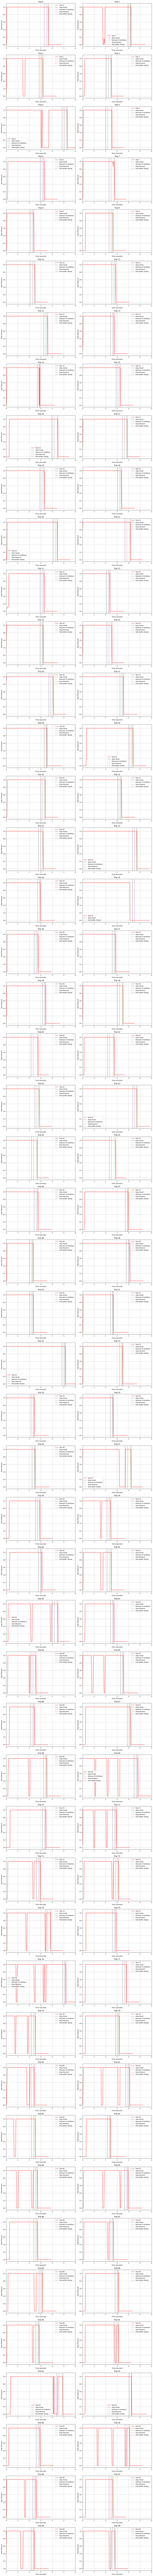

In [313]:
subject = 's016'
condition = 'non_ai'

diaplay_subject_trials(subject, condition, data = shared_control_metrics)